# **0. Load Preliminary Functions**

Code adopted from course https://github.com/mit-6s978/mit-6s978.github.io

# a. Import Libraries and Functions

In [ ]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

# b. MNIST Data Loader

In [ ]:
tensor_transform = transforms.ToTensor()

batch_size = 100
MNIST_dataset = datasets.MNIST(root = "./data",
									train = True,
									download = True,
									transform = tensor_transform)

MNIST_loader = torch.utils.data.DataLoader(dataset = MNIST_dataset,
							   batch_size = batch_size,
								 shuffle = True)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.12MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.39MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# c. Training Function

In [ ]:
from math import e
mse = torch.nn.MSELoss()

def loss_func(model, x, reg_func=None, coeff=1e-3):
    output = model(x)
    recon_loss = torch.nn.functional.binary_cross_entropy(output['imgs'], x, reduction='sum')

    if reg_func is not None:
      reg = reg_func(output)
      reg = reg.sum()
    else:
      reg = 0.0
    return recon_loss + coeff * reg, recon_loss,  reg

def train(dataloader, model, loss_func, optimizer, epochs):
    losses = []

    for epoch in tqdm(range(epochs), desc='Epochs'):
        running_loss = 0.0
        running_reconstruct_loss = 0.0
        running_kl_loss = 0.0
        batch_progress = tqdm(dataloader, desc='Batches', leave=False)

        for iter, (images, labels) in enumerate(batch_progress):
            batch_size = images.shape[0]
            images = images.reshape(batch_size, -1).to(device)
            loss, reconstruct_loss, kl_loss = loss_func(model, images)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_reconstruct_loss += reconstruct_loss.item()
            running_kl_loss += kl_loss.item()
            avg_loss = running_loss / len(MNIST_dataset) * batch_size
            avg_reconstruct_loss = running_reconstruct_loss / len(MNIST_dataset) * batch_size
            avg_kl_loss = running_kl_loss / len(MNIST_dataset) * batch_size
            losses.append(loss.item())

        tqdm.write(f'----\nEpoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}\nAverage Reconstrut Loss: {avg_reconstruct_loss:.4f}\nAverage KL loss: {avg_kl_loss:.8f}\n')

    return losses


# d. Evaluation Function

In [ ]:
def plot_latent_images(model, n, digit_size=28):
    grid_x = np.linspace(-2, 2, n)
    grid_y = np.linspace(-2, 2, n)

    image_width = digit_size * n
    image_height = digit_size * n
    image = np.zeros((image_height, image_width))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
            with torch.no_grad():
                x_decoded = model.decode(z)
            digit = x_decoded.view(digit_size, digit_size).cpu().numpy()
            image[i * digit_size: (i + 1) * digit_size,
                  j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')
    plt.show()


def eval(model):
    original_imgs = torch.cat([MNIST_dataset[i][0] for i in range(5)])
    with torch.no_grad():
      res = model(original_imgs.reshape(5, -1).to(device))
      reconstructed_imgs = res['imgs']
      reconstructed_imgs = reconstructed_imgs.cpu().reshape(*original_imgs.shape)

    fig, axes = plt.subplots(5, 2, figsize=(10, 25))

    for i in range(5):
        original_image = original_imgs[i].reshape(28, 28)
        axes[i, 0].imshow(original_image, cmap='gray')
        axes[i, 0].set_title(f'Original Image {i+1}')
        axes[i, 0].axis('off')

        reconstructed_image = reconstructed_imgs[i].reshape(28, 28)
        axes[i, 1].imshow(reconstructed_image, cmap='gray')
        axes[i, 1].set_title(f'Reconstructed Image {i+1}')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()


# **1. AutoEncoder (AE)**

## a. Model


In [ ]:
class AE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dims):
        super().__init__()

        assert hidden_dims[-1] == 2, "always use 2 as the latent dimension for generating a 2D image grid during evaluation"

        encoder_layers = []
        for in_dim, out_dim in zip([input_dim] + hidden_dims[:-1], hidden_dims):
          encoder_layers.append(torch.nn.Linear(in_dim, out_dim))
          encoder_layers.append(torch.nn.ReLU())
        self.encoder = torch.nn.Sequential(*encoder_layers)
        decoder_layers = []
        for index in range(len(hidden_dims)-1, 0, -1):
          in_dim = hidden_dims[index]
          out_dim = hidden_dims[index-1]
          decoder_layers.append(torch.nn.Linear(in_dim, out_dim))
          decoder_layers.append(torch.nn.ReLU())
        decoder_layers.append(torch.nn.Linear(hidden_dims[0], input_dim))
        decoder_layers.append(torch.nn.Sigmoid())
        self.decoder = torch.nn.Sequential(*decoder_layers)


    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decode(encoded)
        return {"imgs": decoded}

### Test
hidden_dims = [128, 64, 36, 18, 2]
input_dim = 256
test_tensor = torch.randn([1, input_dim]).to(device)

ae_test = AE(input_dim, hidden_dims).to(device)

with torch.no_grad():
  test_out = ae_test(test_tensor)


## b. Loss Functions and Optimizers


In [ ]:
def loss_AE(model, x):
    reconstructed = model(x)['imgs']
    loss = torch.nn.functional.binary_cross_entropy(reconstructed, x, reduction='sum')
    return loss, loss, loss-loss

image_shape = MNIST_dataset[0][0].shape
input_dim = torch.prod(torch.tensor(image_shape)).item()
print("input_dim: ", input_dim)

hidden_dims = [128, 32, 16, 2]

ae = AE(input_dim, hidden_dims).to(device)
print(ae)

optimizer_ae = torch.optim.Adam(ae.parameters(),
                                lr = 1e-3,
                                weight_decay = 1e-8)


input_dim:  784
AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=2, bias=True)
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
)


## c. Training


In [ ]:
#@title Train AE
epochs = 20

log_ae = train(MNIST_loader, ae, loss_AE, optimizer_ae, epochs)


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [1/20], Average Loss: 22526.3082
Average Reconstrut Loss: 22526.3082
Average KL loss: 0.00000000



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [2/20], Average Loss: 20630.0339
Average Reconstrut Loss: 20630.0339
Average KL loss: 0.00000000



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [3/20], Average Loss: 20627.3754
Average Reconstrut Loss: 20627.3754
Average KL loss: 0.00000000



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [4/20], Average Loss: 20623.9363
Average Reconstrut Loss: 20623.9363
Average KL loss: 0.00000000



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [5/20], Average Loss: 20623.8875
Average Reconstrut Loss: 20623.8875
Average KL loss: 0.00000000



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [6/20], Average Loss: 20622.5264
Average Reconstrut Loss: 20622.5264
Average KL loss: 0.00000000



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [7/20], Average Loss: 20620.8280
Average Reconstrut Loss: 20620.8280
Average KL loss: 0.00000000



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [8/20], Average Loss: 20621.0597
Average Reconstrut Loss: 20621.0597
Average KL loss: 0.00000000



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [9/20], Average Loss: 20618.0938
Average Reconstrut Loss: 20618.0938
Average KL loss: 0.00000000



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [10/20], Average Loss: 20617.9884
Average Reconstrut Loss: 20617.9884
Average KL loss: 0.00000000



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [11/20], Average Loss: 20616.9188
Average Reconstrut Loss: 20616.9188
Average KL loss: 0.00000000



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [12/20], Average Loss: 20617.6435
Average Reconstrut Loss: 20617.6435
Average KL loss: 0.00000000



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [13/20], Average Loss: 20616.3827
Average Reconstrut Loss: 20616.3827
Average KL loss: 0.00000000



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [14/20], Average Loss: 20616.8043
Average Reconstrut Loss: 20616.8043
Average KL loss: 0.00000000



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [15/20], Average Loss: 20616.2948
Average Reconstrut Loss: 20616.2948
Average KL loss: 0.00000000



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [16/20], Average Loss: 20615.8626
Average Reconstrut Loss: 20615.8626
Average KL loss: 0.00000000



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [17/20], Average Loss: 20615.5522
Average Reconstrut Loss: 20615.5522
Average KL loss: 0.00000000



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [18/20], Average Loss: 20615.0399
Average Reconstrut Loss: 20615.0399
Average KL loss: 0.00000000



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [19/20], Average Loss: 20613.2072
Average Reconstrut Loss: 20613.2072
Average KL loss: 0.00000000



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [20/20], Average Loss: 20612.2759
Average Reconstrut Loss: 20612.2759
Average KL loss: 0.00000000



## d. Evaluation


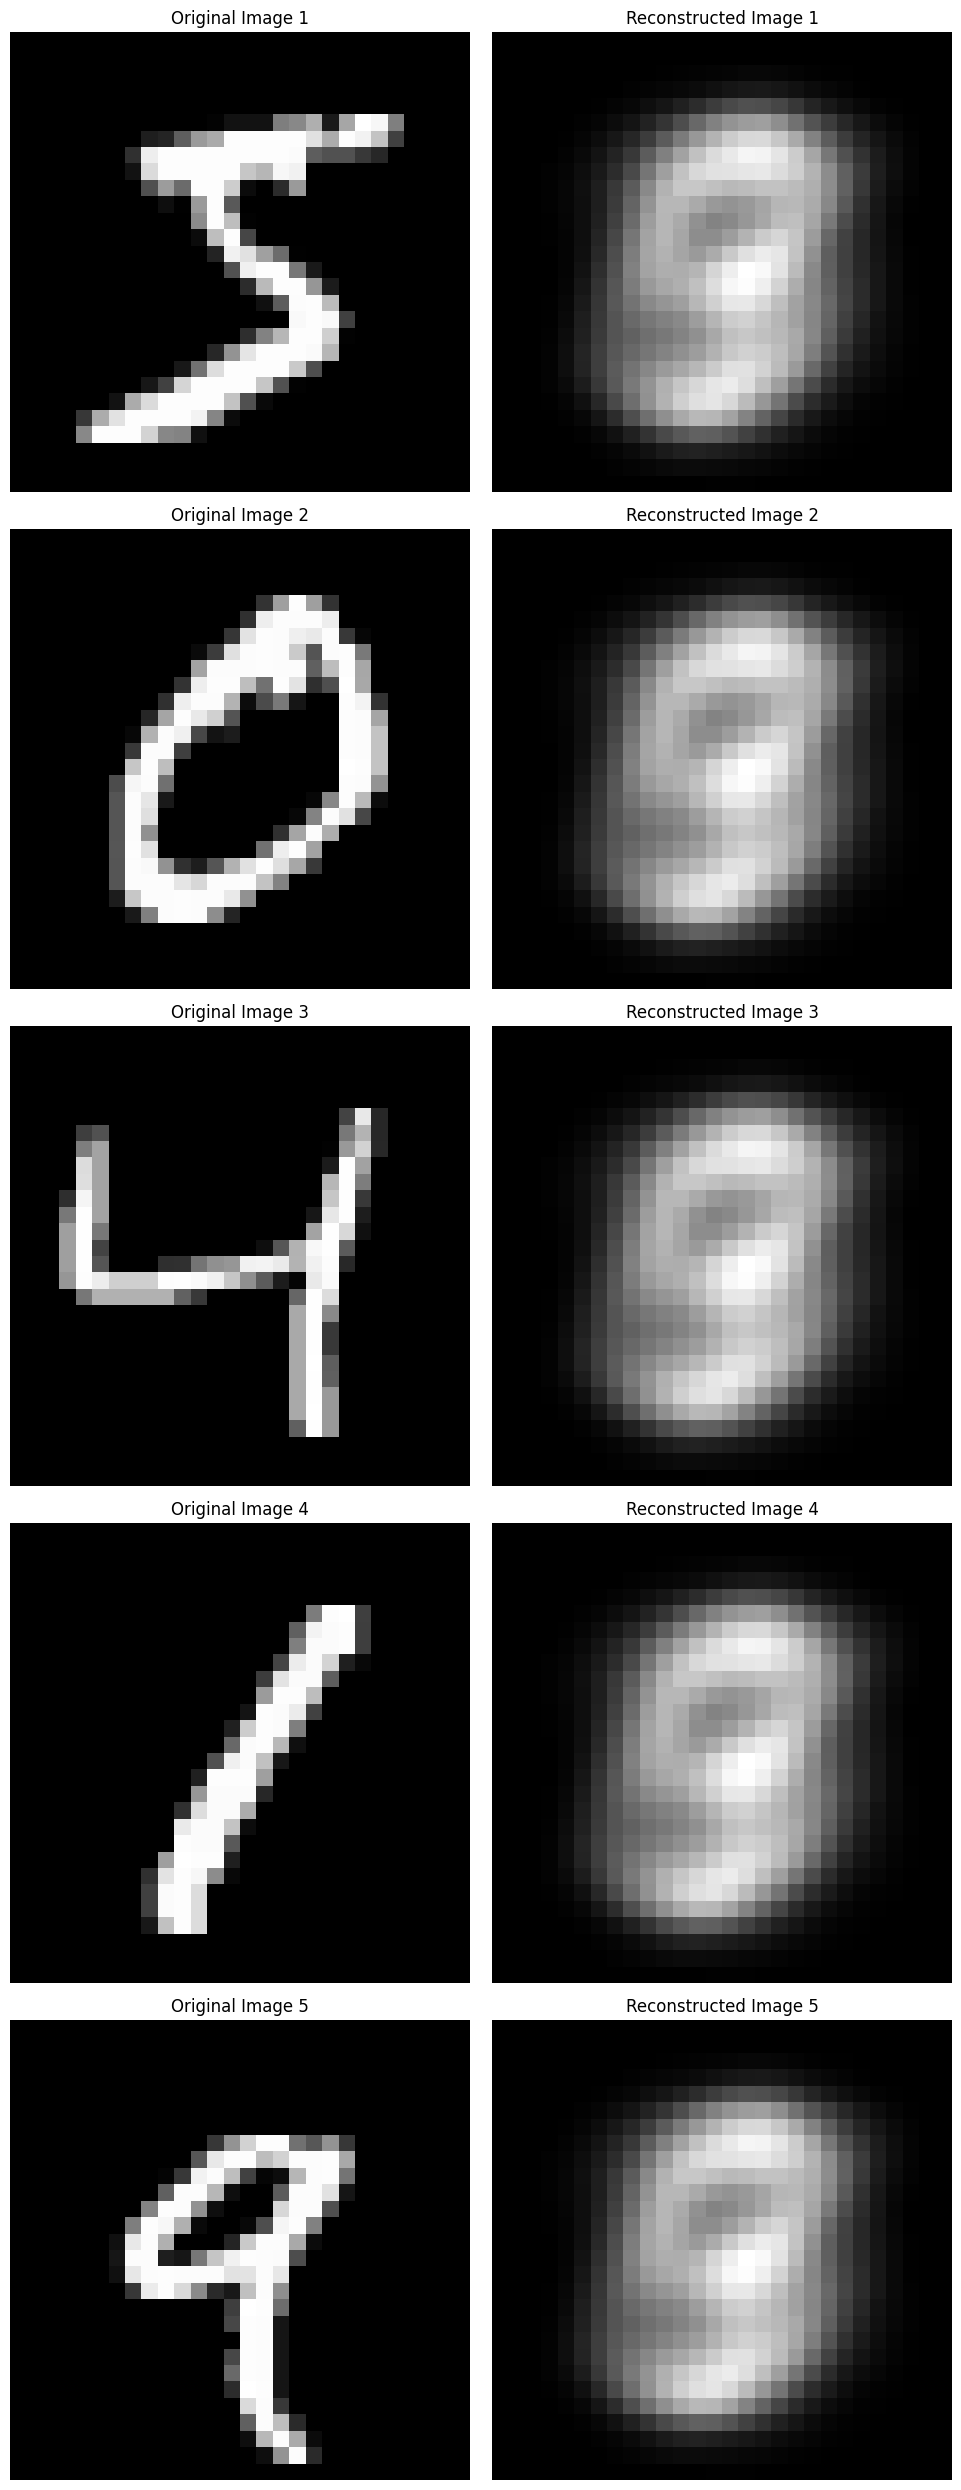

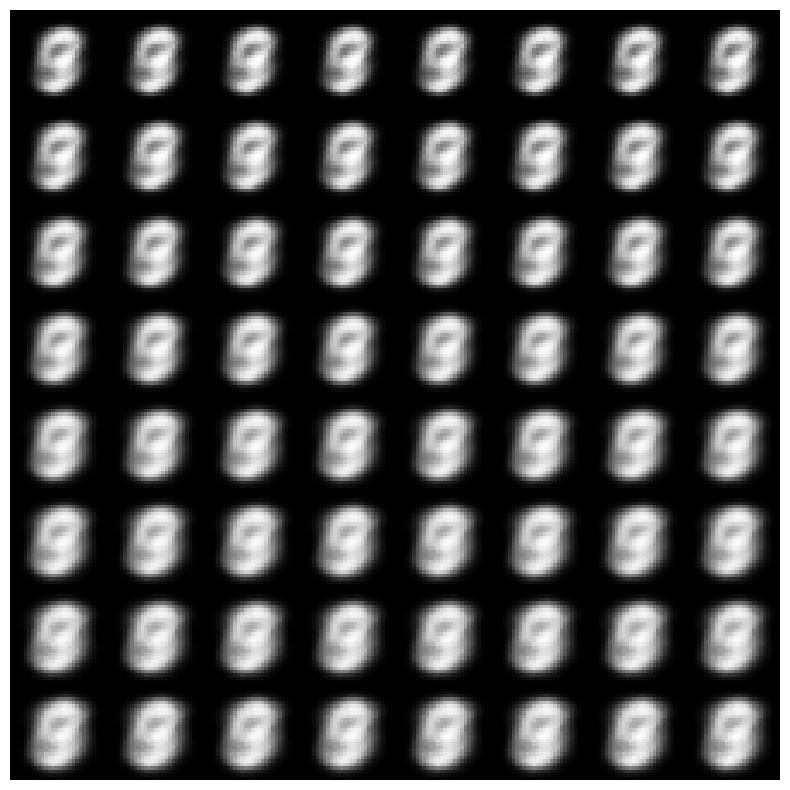

In [ ]:
##################
#@title Evaluate AE
eval(ae)
plot_latent_images(ae, n=8)
##################


# **2. Variational  AutoEncoder (VAE)**
## a. Model

In [ ]:
class VAE(torch.nn.Module):
  def __init__(self, input_dim, hidden_dims, decode_dim=-1, use_sigmoid=True):
      '''
      input_dim: The dimensionality of the input data.
      hidden_dims: A list of hidden dimensions for the layers of the encoder and decoder.
      decode_dim: (Optional) Specifies the dimensions to decode, if different from input_dim.
      '''
      super().__init__()

      self.z_size = hidden_dims[-1] // 2
      assert(self.z_size * 2 == hidden_dims[-1]), "Last hidden layer size should be dividable by 2"
      encoder_layers = []
      for in_dim, out_dim in zip([input_dim] + hidden_dims[:-1], hidden_dims):
        encoder_layers.append(torch.nn.Linear(in_dim, out_dim))
        encoder_layers.append(torch.nn.LeakyReLU(0.1))
      self.encoder = torch.nn.Sequential(*encoder_layers)
      decoder_layers = []
      decoder_layers.append(torch.nn.Linear(self.z_size, hidden_dims[-1]))
      decoder_layers.append(torch.nn.LeakyReLU(0.1))
      first_dim = hidden_dims[0]
      for index in range(len(hidden_dims)-1, 0, -1):
        in_dim = hidden_dims[index]
        out_dim = hidden_dims[index-1]
        decoder_layers.append(torch.nn.Linear(in_dim, out_dim))
        decoder_layers.append(torch.nn.LeakyReLU(0.1))
      decoder_layers.append(torch.nn.Linear(first_dim, decode_dim if decode_dim > 0 else input_dim))
      if use_sigmoid:
        decoder_layers.append(torch.nn.Sigmoid())
      self.decoder = torch.nn.Sequential(*decoder_layers)

  def encode(self, x):
      mean, logvar = torch.split(self.encoder(x), split_size_or_sections=[self.z_size, self.z_size], dim=-1)
      return mean, logvar

  def reparameterize(self, mean, logvar, n_samples_per_z=1):
      bn, latent_dim = mean.shape
      assert n_samples_per_z > 0, "n_samples_per_z should be larger than 0"
      epsilon = torch.randn_like(logvar).to(device)
      std = torch.exp(logvar * 0.5)
      z = mean + std * epsilon
      return z

  def decode(self, z):
      probs = self.decoder(z)
      return probs

  def forward(self, x, n_samples_per_z=1):
      mean, logvar = self.encode(x)

      batch_size, latent_dim = mean.shape
      if n_samples_per_z > 1:
        mean = mean.unsqueeze(1).expand(batch_size, n_samples_per_z, latent_dim)
        logvar = logvar.unsqueeze(1).expand(batch_size, n_samples_per_z, latent_dim)

        mean = mean.contiguous().view(batch_size * n_samples_per_z, latent_dim)
        logvar = logvar.contiguous().view(batch_size * n_samples_per_z, latent_dim)

      z = self.reparameterize(mean, logvar, n_samples_per_z)

      x_probs = self.decode(z)

      x_probs = x_probs.reshape(batch_size, n_samples_per_z, -1)
      x_probs = torch.mean(x_probs, dim=[1])

      return {
          "imgs": x_probs,
          "z": z,
          "mean": mean,
          "logvar": logvar
      }

### Test
hidden_dims = [128, 64, 36, 18, 18]
input_dim = 256
test_tensor = torch.randn([1, input_dim]).to(device)

vae_test = VAE(input_dim, hidden_dims).to(device)

with torch.no_grad():
  print(test_tensor.shape)
  test_out = vae_test(test_tensor)


torch.Size([1, 256])


## b. Loss Functions

### Loss 1: Stoachastic Gradient Variational Bayes (SGVB) Estimator

VAEs are trained by maximizing the Evidence Lower Bound (ELBO) on the marginal log-likelihood:
$$\log p(x) \geq \mathbb{E}_{q(z|x)}[\log\frac{p(x, z)}{q(z|x)}] = \mathrm{ELBO},$$

where $x$ is the data (binary images for MNIST) and $z$ is the latent code.

In practice, the above expectation is estimated using Monte Carlo sampling, yielding the generic Stoachastic Gradient Variational Bayes (SGVB) estimator,
$$\mathrm{ELBO} \approx \sum_{i, j} [\log p(x_i|z_{i, j}) + \log p(z_{i, j}) - \log q(z_{i, j}|x_i)], $$
where $z_{i, j}$ is sampled from $ q(z|x_i) = \mathcal{N}(z;\mu_i, \sigma^2_i \mathbf{I})$. In this assignment, we only sample one $z_{i,j}$ for each $x_i$ (see the function ``reparameterize()`` in the ``VAE()`` class).

In [ ]:
##### Loss 1: SGVB #####
log2pi = torch.log(2.0 * torch.tensor(np.pi)).to(device)
torch_zero = torch.tensor(0.0).to(device)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    ##################
    ### Problem 2(d): finish the implementation for the log-probability for normal distribution with mean and var
    ##################
    var = torch.exp(logvar)
    return -0.5 * log2pi - 0.5 * torch.log(var) - 0.5* (sample - mean)**2 / var

def loss_SGVB(output):
    logpz = log_normal_pdf(output['z'], torch_zero, torch_zero)
    logqz_x = log_normal_pdf(output['z'], output['mean'], output['logvar'])
    return -logpz + logqz_x


### Loss 2: KL Divergence w/o Estimation
In many cases, Monte Carlo sampling is not necessary to estimate all the terms of ELBO, as some terms can be integrated analytically. In the assignment, you derived the cases where the ELBO can be expressed as an analytical KL-divergence plus the expected reconstruction error, specifically when both $q(z|x)$ and $p(z)$ are Gaussian distributions:
$$\mathrm{ELBO} ≈ -D_{KL}(q(z|x) || p(z)) + \sum_{i, j} \log p(x_i|z_{i, j}) = \\\frac{1}{2}\sum_{d}(1+\log((\sigma_d)^2) - (\mu_d)^2 - (\sigma_d)^2) + \sum_{i, j} \log p(x_i|z_{i, j})$$

In [ ]:
##### Loss 2: KL w/o Estimation #####
def loss_KL_wo_E(output):
    var = torch.exp(output['logvar'])
    logvar = output['logvar']
    mean = output['mean']

    return 0.5 * torch.sum(torch.pow(mean, 2)
                            + var - 1.0 - logvar,
                            dim=[1])


## c. Verifying loss 1 == loss 2


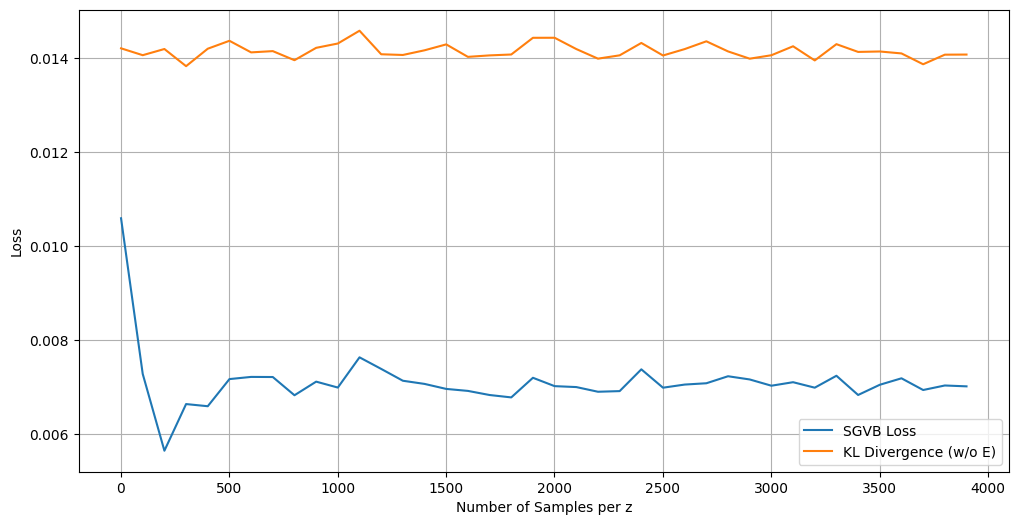

In [ ]:
##################
### Problem 3(b): Check if the analytical KL divergence matches the Monte Carlo estimate.
hidden_dims = [128, 32, 16, 4]
image_shape = MNIST_dataset[0][0].shape
input_dim = torch.prod(torch.tensor(image_shape)).item()
vae_test = VAE(input_dim, hidden_dims).to(device)

all_l_sgvb, all_KL_wo_E = [], []
all_n_samples_per_z = list(range(1, 4000, 100))

with torch.no_grad():
    for n_samples_per_z in all_n_samples_per_z:
        for _, (imgs, _) in enumerate(MNIST_loader):
            batch_size = imgs.shape[0]
            imgs = imgs.reshape(batch_size, -1).to(device)

            output = vae_test(imgs, n_samples_per_z=n_samples_per_z)

            l_sgvb = torch.mean(loss_SGVB(output))
            l_KL_wo_E = torch.mean(loss_KL_wo_E(output))

            all_l_sgvb.append(l_sgvb.item())
            all_KL_wo_E.append(l_KL_wo_E.item())
            break

# Plot the two curves
plt.figure(figsize=(12, 6))

plt.plot(all_n_samples_per_z, all_l_sgvb, label='SGVB Loss')
plt.plot(all_n_samples_per_z, all_KL_wo_E, label='KL Divergence (w/o E)')

plt.xlabel('Number of Samples per z')
plt.ylabel('Loss')
plt.legend()

plt.grid(True)
plt.show()
##################


## d. Training with ELBO loss



In [ ]:
##################
###  Train VAE with ELBO loss
epochs = 5

hidden_dims = [256, 128, 32, 16, 4]
assert hidden_dims[-1] == 4, "always use 4 as the latent dimension for generating a 2D image grid during evaluation"

image_shape = MNIST_dataset[0][0].shape
input_dim = torch.prod(torch.tensor(image_shape)).item()
print("input_dim: ", input_dim)

vae_sgvb = VAE(input_dim, hidden_dims).to(device)
print(vae_sgvb)

optimizer_vae_sgvb = torch.optim.Adam(vae_sgvb.parameters(),
                                lr = 1e-4,
                                weight_decay = 1e-8)

log_vae_sgvb = train(MNIST_loader, vae_sgvb, lambda model, x: loss_func(model, x, reg_func=loss_SGVB, coeff=1), optimizer_vae_sgvb, epochs)
##################


input_dim:  784
VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=128, out_features=32, bias=True)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): LeakyReLU(negative_slope=0.1)
    (8): Linear(in_features=16, out_features=4, bias=True)
    (9): LeakyReLU(negative_slope=0.1)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=4, out_features=16, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=16, out_features=32, bias=True)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Linear(in_features=32, out_features=128, bias=True)
    (7): LeakyReLU(negative_slope=0.1)
    (8): Linear(in_features=128,

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [1/5], Average Loss: 28552.4361
Average Reconstrut Loss: 28392.0180
Average KL loss: 160.41810966



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [2/5], Average Loss: 20083.4086
Average Reconstrut Loss: 19910.5595
Average KL loss: 172.84910974



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [3/5], Average Loss: 19523.1129
Average Reconstrut Loss: 19312.7115
Average KL loss: 210.40140891



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [4/5], Average Loss: 19157.4050
Average Reconstrut Loss: 18928.9620
Average KL loss: 228.44299441



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [5/5], Average Loss: 18951.9337
Average Reconstrut Loss: 18718.5041
Average KL loss: 233.42956553



## e. Evaluation

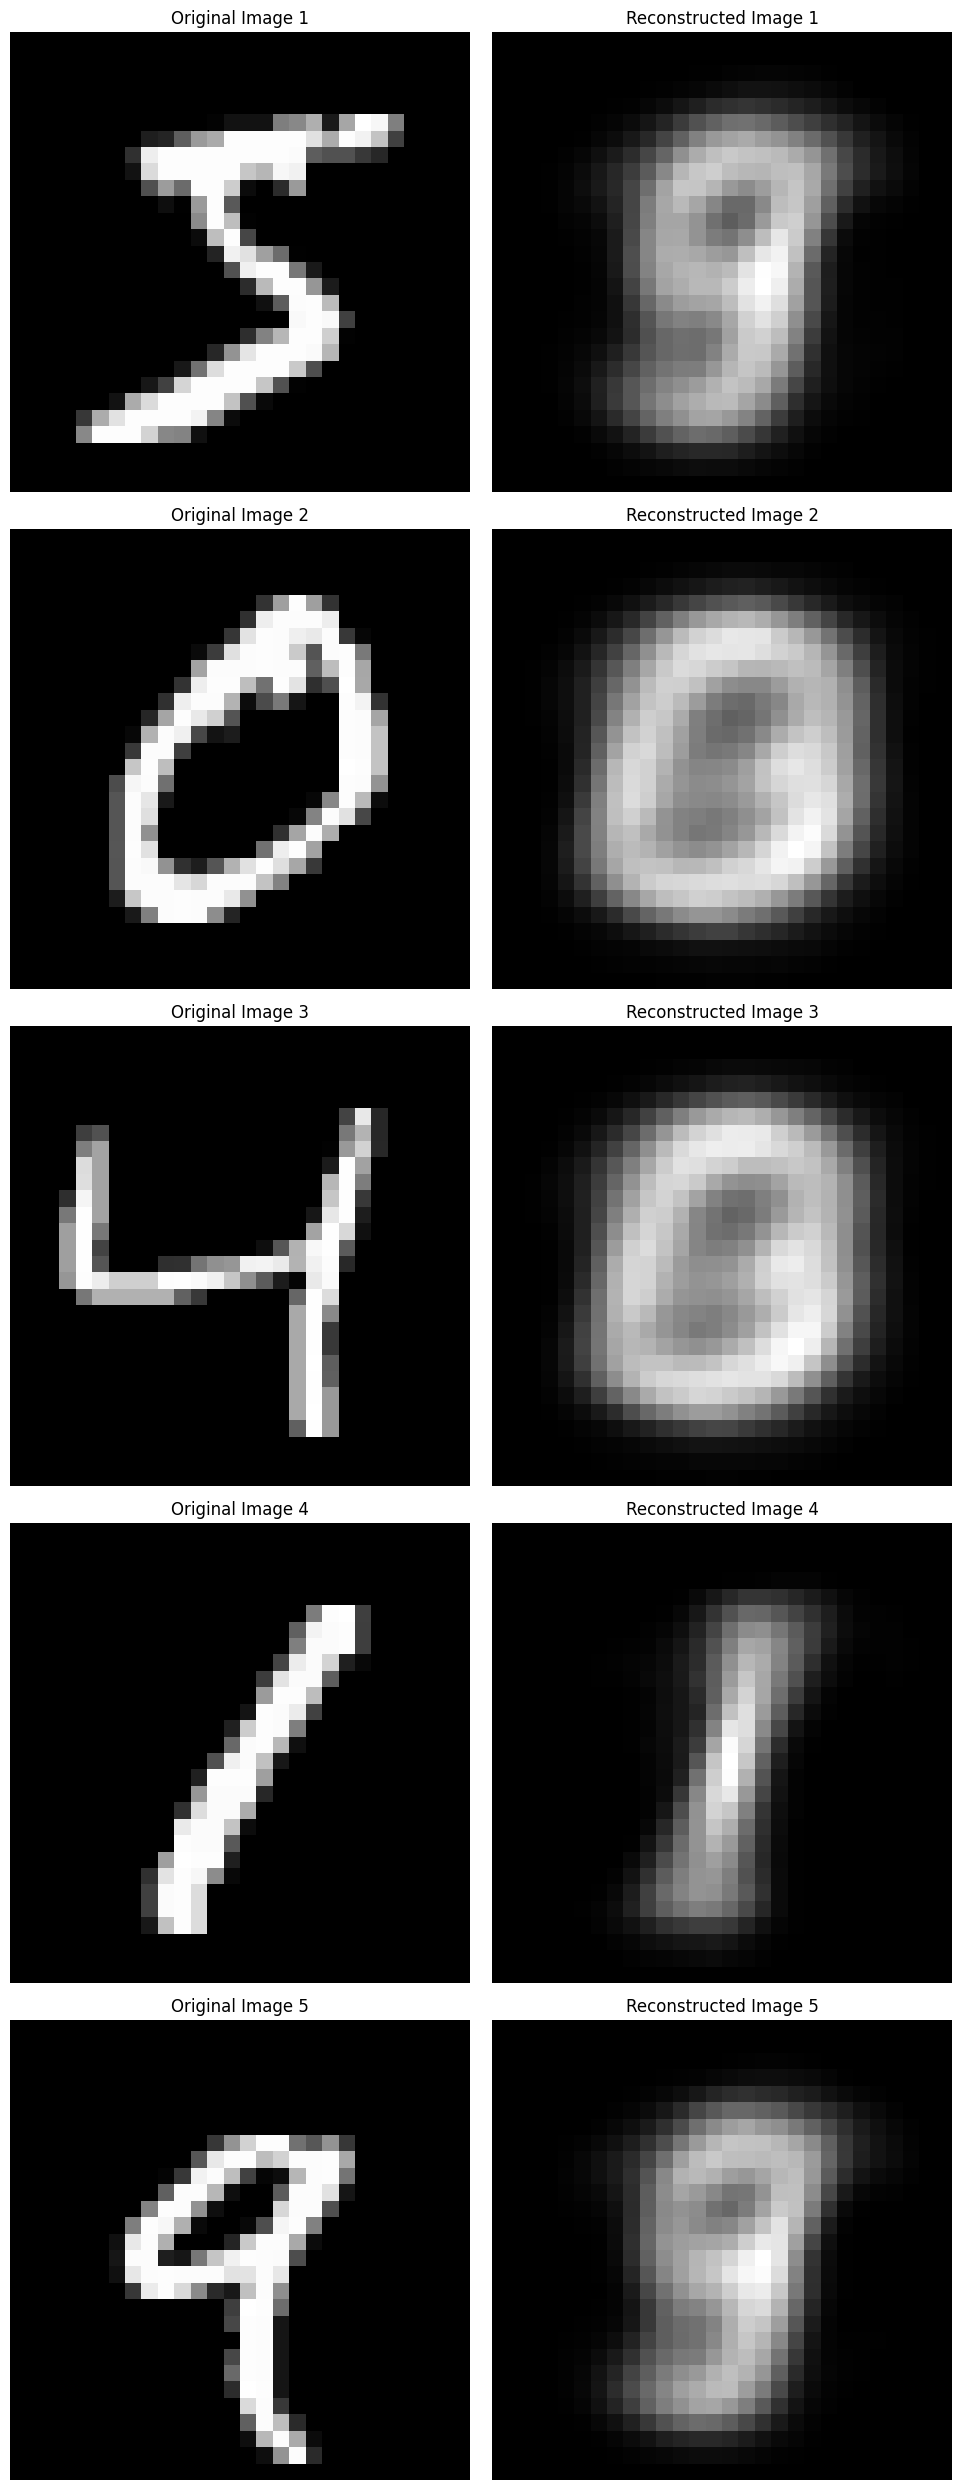

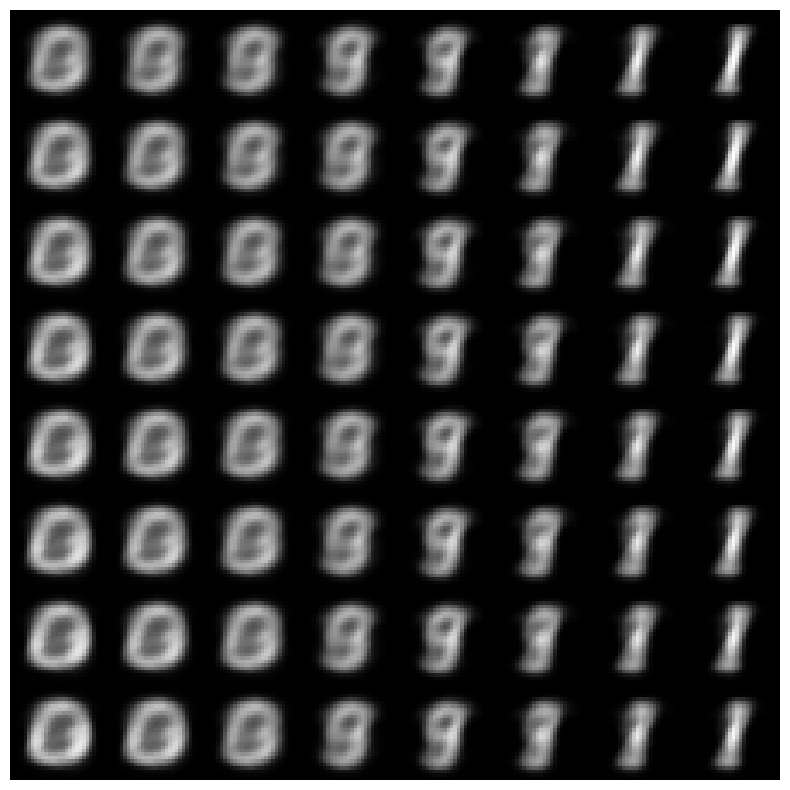

In [ ]:
##################
### Problem 3(c): Evaluate VAE with ELBO loss
eval(vae_sgvb)
plot_latent_images(vae_sgvb, n=8)
##################


## f. Training with KL Divergence w/o Estimation

In [ ]:
##################
#@title Train VAE with analytical KL
epochs = 20

hidden_dims = [400, 4]
# assert hidden_dims[-1] == 4, "always use 4 as the latent dimension for generating a 2D image grid during evaluation"

image_shape = MNIST_dataset[0][0].shape
input_dim = torch.prod(torch.tensor(image_shape)).item()
print("input_dim: ", input_dim)

vae_kl_wo_e = VAE(input_dim, hidden_dims).to(device)
print(vae_kl_wo_e)

optimizer_vae_kl_wo_e = torch.optim.Adam(vae_kl_wo_e.parameters(),
                                lr = 1e-3,
                                weight_decay = 1e-8)

log_vae_kl_wo_e = train(MNIST_loader, vae_kl_wo_e, lambda model, x: loss_func(model, x, reg_func=loss_KL_wo_E, coeff=1), optimizer_vae_kl_wo_e, epochs)
##################


input_dim:  784
VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=400, out_features=4, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=4, out_features=400, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=400, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [1/20], Average Loss: 19410.0034
Average Reconstrut Loss: 19048.0304
Average KL loss: 361.97296457



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [2/20], Average Loss: 16819.5887
Average Reconstrut Loss: 16324.5860
Average KL loss: 495.00268438



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [3/20], Average Loss: 16497.1250
Average Reconstrut Loss: 15985.0810
Average KL loss: 512.04396332



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [4/20], Average Loss: 16280.6731
Average Reconstrut Loss: 15755.7325
Average KL loss: 524.94057826



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [5/20], Average Loss: 16104.2779
Average Reconstrut Loss: 15568.7395
Average KL loss: 535.53836802



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [6/20], Average Loss: 15962.4681
Average Reconstrut Loss: 15419.0211
Average KL loss: 543.44697474



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [7/20], Average Loss: 15849.0819
Average Reconstrut Loss: 15299.7504
Average KL loss: 549.33148493



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [8/20], Average Loss: 15746.9809
Average Reconstrut Loss: 15192.0866
Average KL loss: 554.89426885



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [9/20], Average Loss: 15670.7510
Average Reconstrut Loss: 15112.7938
Average KL loss: 557.95716431



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [10/20], Average Loss: 15591.2466
Average Reconstrut Loss: 15028.4633
Average KL loss: 562.78331284



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [11/20], Average Loss: 15535.4190
Average Reconstrut Loss: 14969.6431
Average KL loss: 565.77583944



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [12/20], Average Loss: 15481.4303
Average Reconstrut Loss: 14912.8186
Average KL loss: 568.61160909



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [13/20], Average Loss: 15419.1961
Average Reconstrut Loss: 14846.2558
Average KL loss: 572.94027893



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [14/20], Average Loss: 15373.8789
Average Reconstrut Loss: 14797.3517
Average KL loss: 576.52714386



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [15/20], Average Loss: 15327.8819
Average Reconstrut Loss: 14750.6594
Average KL loss: 577.22256093



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [16/20], Average Loss: 15281.2189
Average Reconstrut Loss: 14698.5706
Average KL loss: 582.64819936



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [17/20], Average Loss: 15246.9277
Average Reconstrut Loss: 14661.0930
Average KL loss: 585.83478068



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [18/20], Average Loss: 15210.5653
Average Reconstrut Loss: 14622.3285
Average KL loss: 588.23673106



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [19/20], Average Loss: 15185.9562
Average Reconstrut Loss: 14596.7413
Average KL loss: 589.21489675



Batches:   0%|          | 0/600 [00:00<?, ?it/s]

----
Epoch [20/20], Average Loss: 15145.4577
Average Reconstrut Loss: 14553.6225
Average KL loss: 591.83526855



In [ ]:
with torch.no_grad():
  original_imgs = torch.cat([MNIST_dataset[i][0] for i in range(5)])
  out = vae_kl_wo_e(original_imgs.reshape(5, -1).to(device))
  print("mean:", out["mean"].mean().item(), "±", out["mean"].std().item())
  print("logvar:", out["logvar"].mean().item(), "±", out["logvar"].std().item())

mean: 0.06425272673368454 ± 1.360726237297058
logvar: -5.284457206726074 ± 0.607563853263855


## g. Evaluation

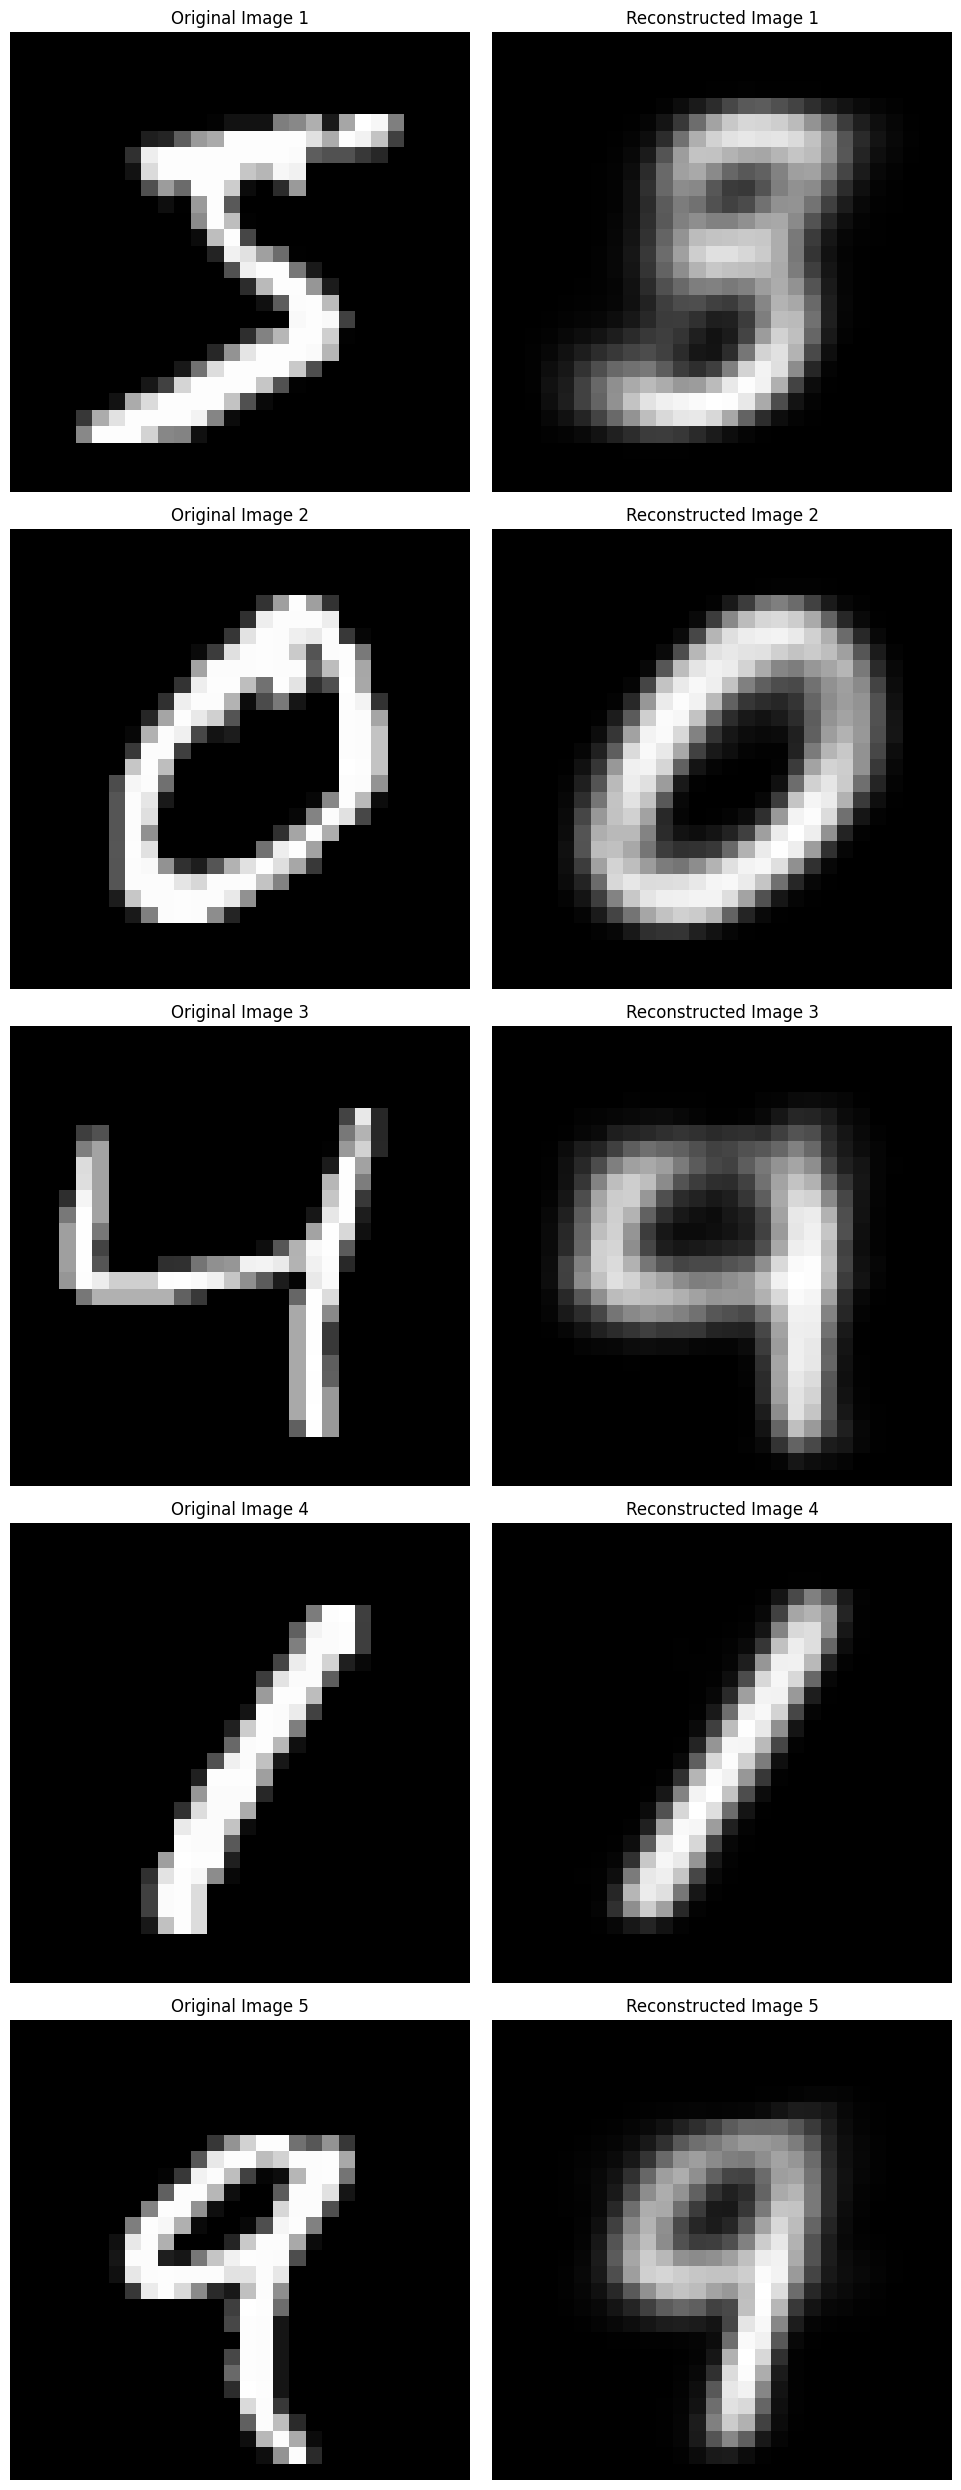

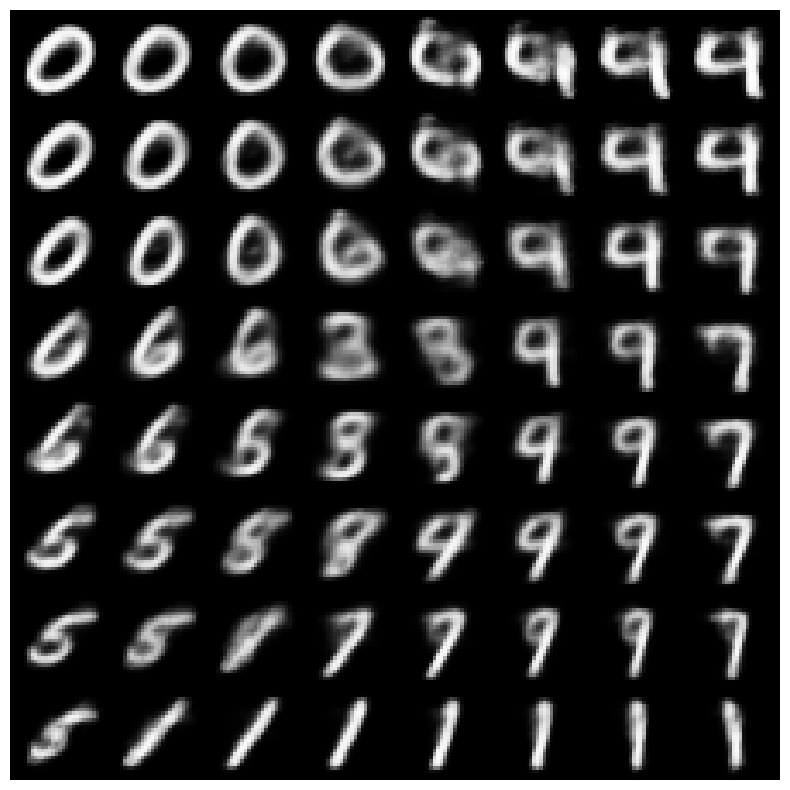

In [ ]:
##################
### Problem 3(c): Evaluate VAE with analytical KL
eval(vae_kl_wo_e)
plot_latent_images(vae_kl_wo_e, n=8)
##################
